## Generate figures for paper
* This notebook generates all figures for the manuscript.
* Note that it also performs some important post-processing of the data, particularly the grouping of degenerate modes.
* There are no long-running calculations in this notebook
* Some additional plots are shown which are not included in paper, such as the error in the multipole fit to extinction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dill as pickle
import seaborn as sns
import os.path as osp

from scipy.constants import c

In [54]:
savefigs = False

savepath = "."
extension = ".pdf"

def savefigure(filename):
    if savefigs:
        plt.savefig(osp.join(savepath, filename+extension), dpi=600)

### Modify plot settings

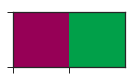

In [3]:
sns.set_style("ticks")

colors = ["dark magenta", "emerald"]
palette_multipoles = sns.xkcd_palette(colors)
sns.palplot(palette_multipoles)

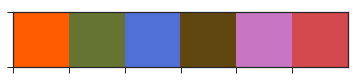

In [4]:
palette_modes = sns.xkcd_palette(["bright orange", "muddy green", "cornflower blue", "mud brown", "orchid", "faded red"])
sns.palplot(palette_modes)

In [5]:
infile = "elliptical_cylinder_calculations.pickle"

with open(infile, "rb") as infile:
    data = pickle.load(infile)
print(data.keys())    

dict_keys(['extinction_modes_x', 'freqs', 'extinction_x', 'a_ey', 'a_ex', 'extinction_y', 'contour', 'extinction_modes_y', 'a_my', 'a_mx', 'refined', 'parameters', 'sim'])


In [6]:
data['parameters']

{'height': 1.1e-06,
 'mesh_tol': 5e-08,
 'radius_x': 1.25e-07,
 'radius_y': 2e-07,
 'rounding': 5e-08}

In [7]:
lrange = np.arange(data['a_ex'].shape[1])
#multipole_correction = 1 #np.sqrt(2*lrange+1)[None, :, None]

cross_section = np.pi*data['parameters']['radius_x']*data['parameters']['radius_y']

a_ex= data['a_ex'] #*multipole_correction
a_mx = data['a_mx'] #*multipole_correction
freqs = data['freqs']
sim = data['sim']

In [8]:
extinction_x = data['extinction_x']
extinction_modes_x = data['extinction_modes_x']
extinction_y = data['extinction_y']
extinction_modes_y = data['extinction_modes_y']
refined = data['refined']
full_modes = refined.add_conjugates()
mode_s = refined.s[0]

## Pick modes of interest for plotting poles and extinction

In [9]:
def group_modes(modes, threshold=1e-2):
    "Group all modes which are degenerate, and which are complex conjugates of each other, within a certain threshold"

    # determine matching for each unique part id
    matched = {}
    for part_id, part_data in modes.modes_of_parts.items():
        s = part_data['s']
        s = s.real + 1j*np.abs(s.imag) # normalise so that conjugate modes get included
        matched[part_id] = []
        unmatched = list(range(len(s)))

        while len(unmatched) > 0:
            current = unmatched.pop()
            ds = np.abs((s[current]-s[unmatched])/s[current])
            matches = np.where(ds < threshold)[0]
            current_group = [current]
            # Traverse in reverse order so that popping does not invalidate other
            # elements
            for m in reversed(matches):
                current_group.append(unmatched[m])
                unmatched.pop(m)
            matched[part_id].append(current_group)
            
    # turn this into a list of mode numbers
    return matched

In [10]:
#num_freqs = 200
#freqs = np.linspace(100e12, 450e12, num_freqs)

### Combine extinction contribution of degenerate and conjugate modes

In [11]:
grouped_modes = list(group_modes(full_modes, 5e-3).values())[0]
extinction_degen_x = np.zeros((len(freqs), len(grouped_modes)), np.complex128)
extinction_degen_y = np.zeros((len(freqs), len(grouped_modes)), np.complex128)

for match_num, match in enumerate(grouped_modes):
    for mode in match:
        extinction_degen_x[:, match_num] += extinction_modes_x[:, mode]
        extinction_degen_y[:, match_num] += extinction_modes_y[:, mode]

significant_groups_x = np.max(np.abs(extinction_degen_x.real), axis=0) > 0.5e-12
significant_groups_y = np.max(np.abs(extinction_degen_y.real), axis=0) > 0.5e-12

wanted_modes_x = []
wanted_modes_y = []
unwanted_modes = []
wanted_groups_x = []
wanted_groups_y = []
import bisect

wanted_extinction_x = []
wanted_extinction_y = []

for match_num, match in enumerate(grouped_modes):
    if significant_groups_x[match_num]:
        mode_num = min(match)
        position = bisect.bisect(wanted_modes_x, mode_num)
        wanted_modes_x.insert(position, mode_num)
        wanted_groups_x.insert(position, match)
        wanted_extinction_x.insert(position, extinction_degen_x[:, match_num])
    elif significant_groups_y[match_num]:
        mode_num = min(match)
        position = bisect.bisect(wanted_modes_y, mode_num)
        wanted_modes_y.insert(position, mode_num)
        wanted_groups_y.insert(position, match)
        wanted_extinction_y.insert(position, extinction_degen_y[:, match_num])
    else:
        for mode_num in match:
            # find one mode, with positive imaginary part
            if full_modes.s[:, mode_num].imag > 0:
                unwanted_modes.append(mode_num)
                break

wanted_extinction_x = np.array(wanted_extinction_x).T
wanted_extinction_y = np.array(wanted_extinction_y).T

In [106]:
wanted_groups_x, wanted_groups_y

([[28, 6], [29, 7], [33, 11]], [[24, 2], [25, 3], [26, 4]])

## Plot poles and extinction as subplots of the same plot

In [12]:
# axis points for wavelength scale
ticks_nm = np.array([2100, 1900, 1700, 1500, 1350, 1200]) #, 1000, 900, 800, 700])
ticks_thz2 = c/ticks_nm*1e-3
#ticks_thz = [freqs[0]*1e-12, freqs[-1]*1e-12]

In [13]:
freqs[0], freqs[-1]

(100000000000000.0, 250000000000000.0)

In [33]:
mode_markers = ['*', 'd', 's', 'o', 'h', 'p', '^', 'o']
mode_names = ["i", "ii", "iii", "iv", "v", "vi"]

In [34]:
start_freq = 130
stop_freq = 250

c:\users\dap124\documents\code\openmodes\openmodes\array.py:254: UserWarning: Indexing LookupArray with iterable is unreliable
  warnings.warn("Indexing LookupArray with iterable is unreliable")


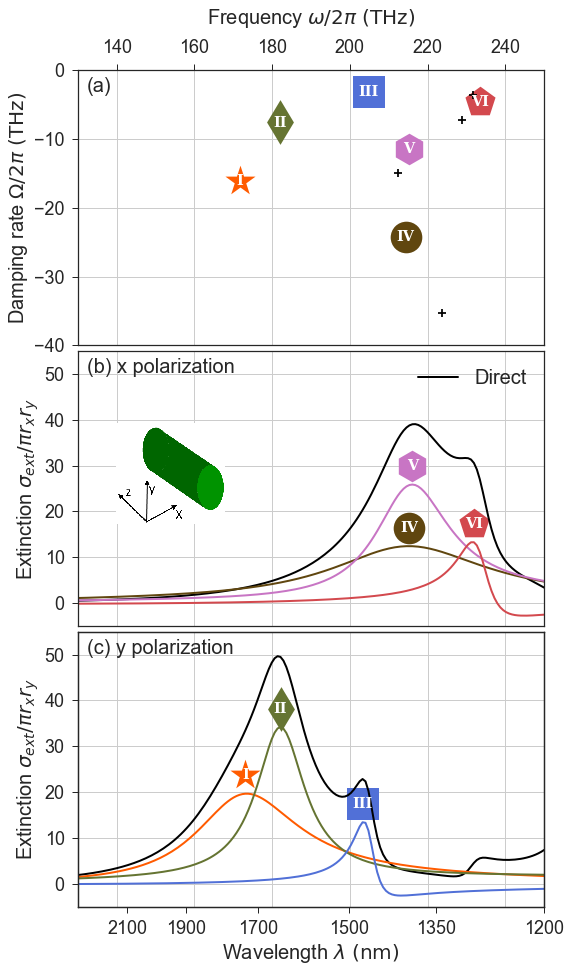

In [104]:
from matplotlib.image import imread

with sns.color_palette(palette_modes):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(8, 14))
    fig.subplots_adjust(left=0.14, right=0.95, top=0.9, bottom=0.07, hspace=0.02)

    start_mode_x = 3   
    
    # The upper plot, a scatter plot of the poles
    for mode_count, this_s in enumerate(mode_s[wanted_modes_x]):
        marker = mode_markers[mode_count+start_mode_x]
        colour = palette_modes[mode_count+start_mode_x]
        mode_name = mode_names[mode_count+start_mode_x]        
        mode_freq = this_s.imag*1e-12/2/np.pi

        ax1.scatter(mode_freq, this_s.real*1e-12/2/np.pi, marker=marker,
                    c=colour, linewidths=0, s=1000, clip_on=False)

        ax1.text(mode_freq, this_s.real*1e-12/2/np.pi, mode_name,
                 color='white', ha='center', va='center', family='serif', size='large', weight='bold')
        
        # the marker on the lower curve
        mode_index = np.argmax(np.abs(wanted_extinction_x[:, mode_count].real))
        mode_x = freqs[mode_index]*1e-12
        mode_y = wanted_extinction_x[mode_index, mode_count].real/cross_section
        mode_y += 4*np.sign(mode_y)
        
        ax2.scatter(mode_x, mode_y, marker=marker,
                    c=colour, linewidths=0, s=1000, clip_on=False)

        ax2.text(mode_x, mode_y, mode_name,
                 color='white', ha='center', va='center', family='serif', size='large', weight='bold')
        
        
    start_mode_y = 0
    
    # The upper plot, a scatter plot of the poles
    for mode_count, this_s in enumerate(mode_s[wanted_modes_y]):
        marker = mode_markers[mode_count+start_mode_y]
        colour = palette_modes[mode_count+start_mode_y]
        mode_name = mode_names[mode_count+start_mode_y]
        mode_freq = this_s.imag*1e-12/2/np.pi

        ax1.scatter(mode_freq, this_s.real*1e-12/2/np.pi, marker=marker,
                    c=colour, linewidths=0, s=1000, clip_on=False)

        ax1.text(mode_freq, this_s.real*1e-12/2/np.pi, mode_name,
                 color='white', ha='center', va='center', family='serif', size='large', weight='bold')        
        
        # the marker on the lower curve
        mode_index = np.argmax(np.abs(wanted_extinction_y[:, mode_count].real))
        mode_x = freqs[mode_index]*1e-12
        mode_y = wanted_extinction_y[mode_index, mode_count].real/cross_section
        mode_y += 4*np.sign(mode_y)
        
        ax3.scatter(mode_x, mode_y, marker=marker,
                    c=colour, linewidths=0, s=1000, clip_on=False)

        ax3.text(mode_x, mode_y, mode_name,
                 color='white', ha='center', va='center', family='serif', size='large', weight='bold')
        
        
    ax1.scatter(mode_s[unwanted_modes].imag*1e-12/2/np.pi, mode_s[unwanted_modes].real*1e-12/2/np.pi,
                marker='+', c='k', linewidths=2, s=80)
    ax1.set_ylim(-40, 0)
    ax1.set_xlim(start_freq, stop_freq)
    ax1.set_xlabel(r'Frequency $\omega/2\pi\ \mathrm{(THz)}$', fontsize=20, labelpad=15)
    ax1.set_ylabel(r'Damping rate $\Omega/2\pi\ \mathrm{(THz)}$', fontsize=20)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.text(0.02, 0.92, "(a)", fontsize=20, transform=ax1.transAxes)

    ax1.set_yticks([0, -10, -20, -30, -40])#-25, -50])#, -75, -100, -125])
    ax1.tick_params(bottom=False, right=False, labelsize=18)
    ax1.grid(True)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 

    # Add an inset figure showing polarisation
    ax5 = fig.add_axes([0.2, 0.45, 0.2, 0.1])
    ax5.imshow(imread("inset-elliptical.png"))
    ax5.axis('off')
    
    # The lower plot, a line plot of extinction
    ax2.plot(freqs*1e-12, extinction_x.real/cross_section, 'k', linewidth=2)

    for line_count, w_ex in enumerate(wanted_extinction_x.T):
        ax2.plot(freqs*1e-12, w_ex.real/cross_section, linewidth=2, color=palette_modes[start_mode_x+line_count])
    
    #ax2.plot(freqs*1e-12, wanted_extinction_x.real/cross_section, linewidth=2)
    ax2.tick_params(top=False, right=False, bottom=False, labelsize=18)
    ax2.text(0.02, 0.92, "(b) x polarization", fontsize=20, transform=ax2.transAxes)
   
    ax2.set_xlim(start_freq, stop_freq)
    ax2.grid(True)
    ax2.set_xticklabels([])
    #ax2.set_yticks([-4, -2, 0, 2, 4, 6, 8])
    ax2.set_ylim(-5, 55)
    ax2.set_ylabel(r'Extinction $\sigma_{ext}/\pi r_x r_y$', fontsize=20)
    ax2.legend(["Direct"], fontsize=20, loc="upper right")

    # The lower plot, a line plot of extinction
    ax3.plot(freqs*1e-12, extinction_y.real/cross_section, 'k', linewidth=2)
    
    for line_count, w_ey in enumerate(wanted_extinction_y.T):
        ax3.plot(freqs*1e-12, w_ey.real/cross_section, linewidth=2, color=palette_modes[start_mode_y+line_count])

    ax4 = ax3.twiny()
        
    ax3.tick_params(top=False, right=False, bottom=False, labelsize=18)
    ax3.text(0.02, 0.92, "(c) y polarization", fontsize=20, transform=ax3.transAxes)
   
    ax3.set_xlim(start_freq, stop_freq)
    ax3.grid(True)
    ax3.set_xticklabels([])
    #ax3.set_yticks([-4, -2, 0, 2, 4, 6, 8])
    ax3.set_ylim(-5, 55)
    ax3.set_ylabel(r'Extinction $\sigma_{ext}/\pi r_x r_y$', fontsize=20)
    #ax3.legend(["Direct"], fontsize=20, loc="upper right")
    
    # Add an additional X axis giving the wavelength in nm

    ax4.set_xticks(ticks_thz2)
    ax4.set_xticklabels(ticks_nm)
    ax4.set_xlim(start_freq, stop_freq)
    
    ax4.set_xlabel(r'Wavelength $\lambda\ \mathrm{(nm)}$', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=18)
    ax4.xaxis.tick_bottom()
    ax4.xaxis.set_label_position('bottom') 

    
    savefigure('ellipse-poles-plus-extinction')
    plt.show()    

In [91]:
wanted_extinction_x.shape

(200, 3)

## Plotting mode currents/surface fields along with multipole decomposition

In [78]:
import matplotlib.gridspec as gridspec

def plot_current_multipoles(current, s, num_multipoles, image, marker_colour, marker, mode_name, filename=None):
    a_e, a_m = sim.multipole_decomposition(current, num_multipoles, s)

    a_e_list = np.zeros(num_multipoles+1)
    a_m_list = np.zeros_like(a_e_list)

    lrange = np.arange(num_multipoles+1)
    
    for l in lrange[1:]:        
        # normalise to scattering contribution
        for m in range(-l, l+1):
            a_e_list[l] += np.abs(a_e[l, m])**2#*(2*l+1)
            a_m_list[l] += np.abs(a_m[l, m])**2#*(2*l+1)

    max_element = np.sum(a_e_list)+np.sum(a_m_list)
    
    a_e_list /= max_element
    a_m_list /= max_element

    a_e_list = np.sqrt(np.abs(a_e_list))
    a_m_list = np.sqrt(np.abs(a_m_list))

    width = 0.6
    ind = np.arange(1, len(a_e_list))

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[6,4])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 1])
    ax3 = plt.subplot(gs[:, 0])
    
    fig.subplots_adjust(left=-0.02, right=0.98, wspace=0.1, bottom=0.15, top=0.99, hspace=0.05)
    
    electric_colours = palette_multipoles[0] #:3]
    magnetic_colours = palette_multipoles[1] #3:]
    bars_elec = ax1.bar(ind-0.5*width, a_e_list[1:], width, color=electric_colours,
                        label="electric", edgecolor=electric_colours, linewidth=0)
    bars_mag = ax2.bar(ind-0.5*width, a_m_list[1:], width, color=magnetic_colours,
                       label="magnetic", edgecolor=magnetic_colours, linewidth=0)
    
    ax1.text(0.6, 0.7, "Electric", horizontalalignment='left',
      verticalalignment='bottom',
      transform=ax1.transAxes, fontsize=24)
    ax2.text(0.6, 0.7, "Magnetic", horizontalalignment='left',
      verticalalignment='bottom',
      transform=ax2.transAxes, fontsize=24)
    ax2.set_xlabel("Multipole order $l$", fontsize=20)
    ax1.set_ylabel("$|a|$", fontsize=24)
    ax2.set_ylabel("$|b|$", fontsize=24)

    ax1.xaxis.set_ticks([])
    ax2.xaxis.set_ticks(lrange[1:])
    
    for ax in ax1, ax2:
        ax.yaxis.set_ticks([]) #[0, 1])
        ax.set_ylim(0, 1)
        ax.set_xlim(0.5, num_multipoles+0.5)
        ax.yaxis.tick_right()
    
        ax.tick_params(top=False, right=True, left=False, labelsize=18)

    # display the image, and clip it
    ax3.imshow(imread(image)[:, 150:-40])
    
    mode_x, mode_y = 0.09, 0.96 #0.93
    ax3.scatter(mode_x, mode_y, marker=marker, transform=ax3.transAxes,
                c=marker_colour, linewidths=0, s=1500, clip_on = False, zorder=10)
    ax3.text(mode_x, mode_y, mode_name, zorder=11, transform=ax3.transAxes,
             color='white', ha='center', va='center', family='serif', size='larger', weight='bold')        
    
#     ax3.scatter(0, 0, s=800, c=marker_colour, marker=marker, linewidths=0)
#     ax3.annotate(mode_name, (120, 27), fontsize=24, family='serif')
    ax3.axis('off')
    
    savefigure(filename)
    plt.show()

### Produce a single current vector for a given a set of degenerate and conjugate modes
Construct a model based on all of these modes, solve the currents at the imaginary part of resonant frequency for positive $\omega_n$

In [79]:
from openmodes.sources import PlaneWaveSource
pw = PlaneWaveSource([1, 0, 0], [0, 0, 1], p_inc=1.0)

from openmodes.model import ModelMutualWeight

def group_current(modes, group, source):
    part = modes.parent_part
    s = 1j*np.abs(modes.s[0, group[0]].imag)
    
    which_modes = modes.select(group)
    model = ModelMutualWeight(which_modes)
    V = sim.source_vector(source, s, parent=part)
    V_modes = which_modes.vl.dot(V)
    Z = model.impedance(s)
    I_modes = Z.solve(V_modes)
    I = which_modes.vr.dot(I_modes)
    return I, s
        

## Export the mode currents
These currents are in .vtk format, which can be read by the open-source program [ParaView](http://www.paraview.org/). This program is used to generate a .png image of each set of each mode's current.

In [94]:
wanted_groups = wanted_groups_y+wanted_groups_x

In [107]:
for count, group in enumerate(wanted_groups):
    I, s = group_current(full_modes, group, pw)
    filename = "elliptical-cylinder-modes-{:02d}.vtp".format(count)
    if savefigs:
        sim.plot_3d(solution=I, output_format='vtk', filename=filename, normalise_scalars=True)

After the .vtk files have been processed by ParaView to produce .png files, these are loaded back into the notebook to produce a fully annotated figure with currents and multipole expansion

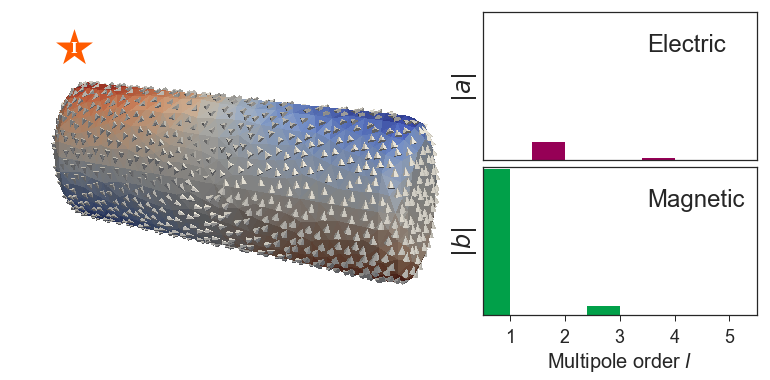

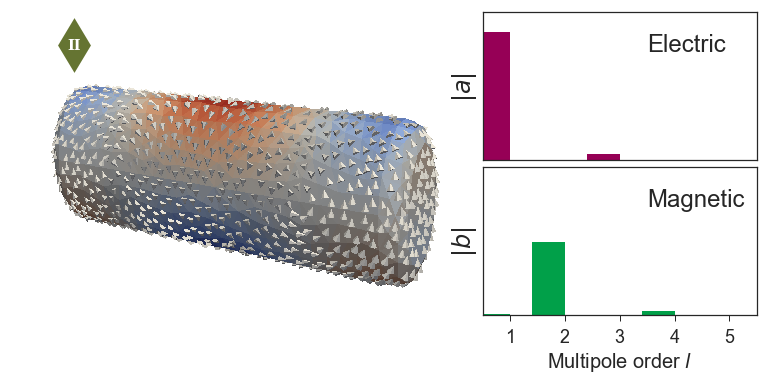

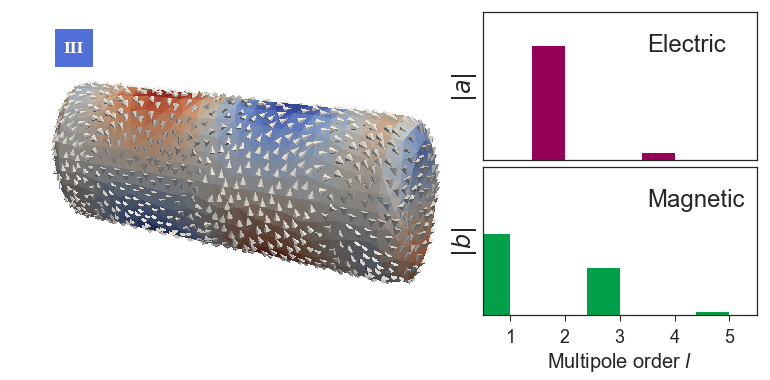

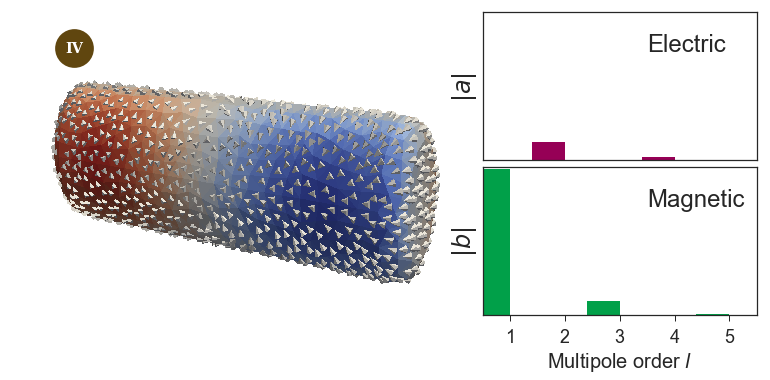

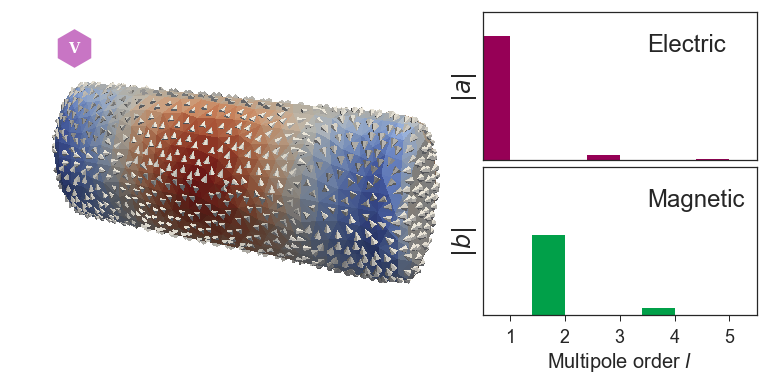

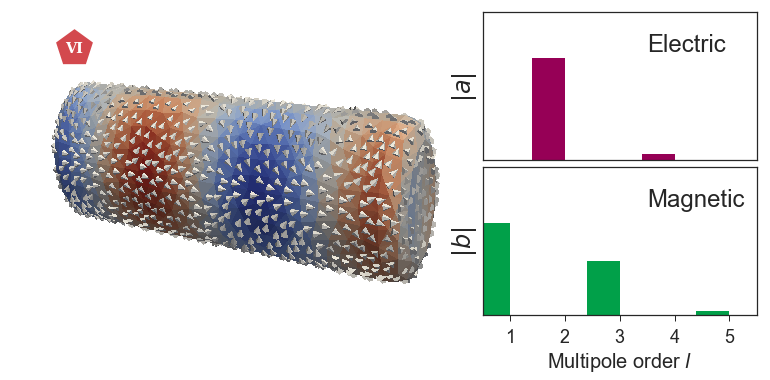

In [112]:
images = ["elliptical-cylinder-modes-{:02d}.png".format(n) for n in range(6)]

for count, (group, image, mode_name) in enumerate(zip(wanted_groups, images, mode_names)):
    I, s = group_current(full_modes, group, pw)
    filename = "elliptical-combined-{:02d}".format(count)
    plot_current_multipoles(I, s, 5, image, palette_modes[count], mode_markers[count], mode_name, filename=filename)